# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Tuning

***

**What is the objective of this file?**

To process the datasets to make it suitable for use in Model Training and Model Evaluation.

## Checklist

- Ensure that you have installed the necessary libraries needed to execute the training process. 
- You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 0. Preparations

In [23]:
#Python Libraries
import time, threading, math
from datetime import datetime

#Data/Dataset libraries
import pandas as pd
import numpy as np

#Split Sampler/Data Splitting
from sklearn.model_selection import train_test_split

#Oversampler
from imblearn.over_sampling import SMOTEN

#Label Encoding
from sklearn.preprocessing import LabelEncoder

#Timer
start = end = 0
LOG_FILENAME = "Dataset_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    global DATASET_FILENAME
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{DATASET_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

# 1. Import Datasets

**Notice:** 
1. Make sure check the value of line 3 of the block below before running.
2. A backup of the processed datasets is already found in `/Processed Datasets` folder. Simply unzip it to replace the contents of `/Processed Datasets/IB` and `/Processed Datasets/TB` folders.

In [24]:
#Filenames
filename = ["oliveira_lite.csv", "oliveira.csv", "oliveira_labelled.csv"]
DATASET_FILENAME = filename[2] # <== CHANGE THIS ACCORDINGLY
API_LIST = "api_calls.txt"

#Load list of API calls
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

#Importing Datasets
oli = pd.read_csv(DATASET_FILENAME)
print("Oliveira Info:")
oli.info()

Oliveira Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 103 entries, hash to type
dtypes: int64(101), object(2)
memory usage: 34.5+ MB


In [25]:
APIS

['NtOpenThread',
 'ExitWindowsEx',
 'FindResourceW',
 'CryptExportKey',
 'CreateRemoteThreadEx',
 'MessageBoxTimeoutW',
 'InternetCrackUrlW',
 'StartServiceW',
 'GetFileSize',
 'GetVolumeNameForVolumeMountPointW',
 'GetFileInformationByHandle',
 'CryptAcquireContextW',
 'RtlDecompressBuffer',
 'SetWindowsHookExA',
 'RegSetValueExW',
 'LookupAccountSidW',
 'SetUnhandledExceptionFilter',
 'InternetConnectA',
 'GetComputerNameW',
 'RegEnumValueA',
 'NtOpenFile',
 'NtSaveKeyEx',
 'HttpOpenRequestA',
 'recv',
 'GetFileSizeEx',
 'LoadStringW',
 'SetInformationJobObject',
 'WSAConnect',
 'CryptDecrypt',
 'GetTimeZoneInformation',
 'InternetOpenW',
 'CoInitializeEx',
 'CryptGenKey',
 'GetAsyncKeyState',
 'NtQueryInformationFile',
 'GetSystemMetrics',
 'NtDeleteValueKey',
 'NtOpenKeyEx',
 'sendto',
 'IsDebuggerPresent',
 'RegQueryInfoKeyW',
 'NetShareEnum',
 'InternetOpenUrlW',
 'WSASocketA',
 'CopyFileExW',
 'connect',
 'ShellExecuteExW',
 'SearchPathW',
 'GetUserNameA',
 'InternetOpenUrlA',
 

In [26]:
#Previewing Dataset
oli.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware,type
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,1,trojan
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,240,117,71,297,135,171,215,35,1,pua
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,112,123,65,112,123,65,113,112,1,trojan
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,302,208,302,187,208,302,228,302,1,trojan
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,260,40,209,260,141,260,141,260,1,trojan


In [27]:
print("Oliveira Label Counts")
print("0 as Benign, 1 as Malicious")
oli.malware.value_counts()

Oliveira Label Counts
0 as Benign, 1 as Malicious


malware
1    41124
0     2752
Name: count, dtype: int64

Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

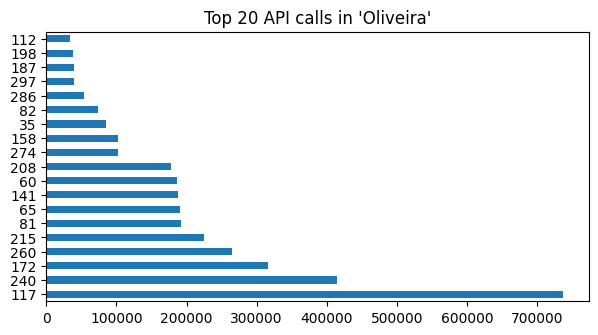

In [28]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[1:101]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [29]:
oli_unique.unique()

array([306, 305, 303, 302, 301, 298, 297, 296, 295, 294, 293, 292, 291,
       290, 289, 288, 287, 286, 285, 284, 283, 281, 280, 279, 278, 277,
       276, 275, 274, 272, 271, 270, 269, 268, 267, 266, 264, 263, 262,
       261, 260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 249, 248,
       247, 245, 244, 243, 240, 239, 236, 235, 234, 232, 231, 230, 229,
       228, 226, 225, 224, 222, 221, 220, 218, 217, 216, 215, 214, 213,
       212, 211, 210, 209, 208, 207, 206, 205, 204, 202, 201, 200, 199,
       198, 197, 196, 195, 194, 192, 190, 188, 187, 185, 184, 183, 182,
       181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 168,
       166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 154, 153,
       151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139,
       136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 125, 124, 123,
       122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110,
       109, 108, 107, 106, 104, 103, 100,  99,  98,  97,  96,  9

# 2. Dataset Preparation

## 2.1. Dataset Cleaning and Dataset Formatting

In [30]:
#Remove falsely labelled malicious samples
oli = oli[oli['type'] != '_']

#Removing hash column
hash_col = oli.pop('hash')
#Remove type column
type_col = oli.pop('type')
#Re-arranging column positions
label_col = oli.pop('malware')
oli = pd.concat([label_col, oli], axis=1)
oli = pd.concat([oli, hash_col], axis=1) # <=== This will be retained for the benefit of model evaluation.

oli

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash
0,1,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,071e8c3f8922e186e57548cd4c703a5d
1,1,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,33f8e6d08a6aae939f25a8e0d63dd523
2,1,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,b68abd064e975e1c6d5f25e748663076
3,1,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,72049be7bd30ea61297ea624ae198067
4,1,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,c9b3700a77facf29172f32df6bc77f48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,e3d6d58faa040f0f9742c9d0eaf58be4
43872,1,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,159,224,82,9b917bab7f32188ae40c744f2be9aaf8
43873,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,35a18ee05f75f04912018d9f462cb990
43874,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,654139d715abcf7ecdddbef5a84f224b


## 2.2. Inverse Data Encoding

*Encoded API calls to String API Calls*

In [31]:
#Inverse Label Encoding
def inverse_label(item):
    global APIS
    return item.map(lambda x: APIS[int(x)])
start_time()
oli.iloc[:, 1:101] = oli.iloc[:, 1:101].apply(inverse_label, axis=1, result_type='reduce')
end_time("Inverse Data Encode")

oli.head()

C:\Users\ejose\AppData\Local\Temp\ipykernel_14200\1737707763.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0                      RegOpenKeyExA
1            GetSystemTimeAsFileTime
2        SetUnhandledExceptionFilter
3            GetSystemTimeAsFileTime
4            GetSystemTimeAsFileTime
                    ...             
43871        GetSystemTimeAsFileTime
43872        GetSystemTimeAsFileTime
43873        GetSystemTimeAsFileTime
43874        GetSystemTimeAsFileTime
43875                  RegOpenKeyExA
Name: t_0, Length: 42202, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oli.iloc[:, 1:101] = oli.iloc[:, 1:101].apply(inverse_label, axis=1, result_type='reduce')
C:\Users\ejose\AppData\Local\Temp\ipykernel_14200\1737707763.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0 

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash
0,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,071e8c3f8922e186e57548cd4c703a5d
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,LoadResource,LdrLoadDll,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,33f8e6d08a6aae939f25a8e0d63dd523
2,1,SetUnhandledExceptionFilter,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,RegCloseKey,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,RegEnumKeyExA,RegOpenKeyExA,b68abd064e975e1c6d5f25e748663076
3,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,NtAllocateVirtualMemory,NtWriteVirtualMemory,NtAllocateVirtualMemory,NtWriteVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,NtWriteVirtualMemory,NtProtectVirtualMemory,NtWriteVirtualMemory,72049be7bd30ea61297ea624ae198067
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,c9b3700a77facf29172f32df6bc77f48


Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

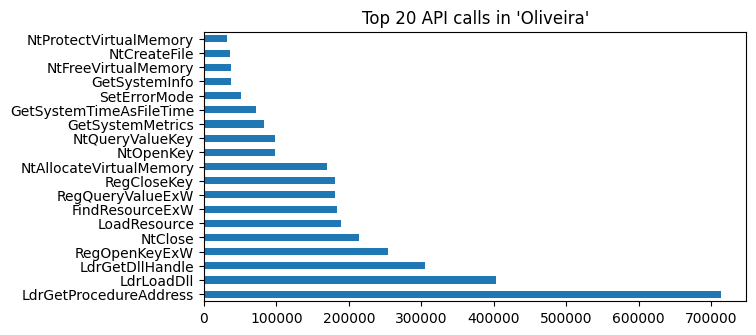

In [32]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[1:101]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [33]:
oli_unique.unique()

array(['timeGetTime', 'socket', 'shutdown', 'setsockopt', 'sendto',
       'send', 'select', 'recvfrom', 'recv', 'listen', 'ioctlsocket',
       'getsockname', 'gethostbyname', 'getaddrinfo', 'connect',
       'closesocket', 'bind', '__exception__', 'WriteProcessMemory',
       'WriteConsoleW', 'WriteConsoleA', 'WSAStartup', 'WSASocketW',
       'WSASocketA', 'WSARecv', 'UuidCreate', 'UnhookWindowsHookEx',
       'Thread32Next', 'Thread32First', 'StartServiceW', 'StartServiceA',
       'SizeofResource', 'ShellExecuteExW', 'SetWindowsHookExW',
       'SetWindowsHookExA', 'SetUnhandledExceptionFilter', 'SetStdHandle',
       'SetInformationJobObject', 'SetFileTime', 'SetFilePointerEx',
       'SetFilePointer', 'SetFileInformationByHandle',
       'SetFileAttributesW', 'SetErrorMode', 'SetEndOfFile',
       'SendNotifyMessageW', 'SearchPathW', 'SHGetSpecialFolderLocation',
       'SHGetFolderPathW', 'RtlRemoveVectoredExceptionHandler',
       'RtlDecompressBuffer', 'RtlAddVectoredExceptio

## 2.3. Feature Duplicate Processing

*Building Time-based and Instance-Based Datasets*

In [34]:
TB = oli.copy(deep=True) #Time-based behavior (same as original)
IB = oli.copy(deep=True) #Instance-based behavior (to be created)

start_time()
print("Transposing IB...")
IB.transpose()
print("IB Transposed!")
print("Removing duplicates...")
print("Row:", end=" ")
for r in range(oli.shape[0]):
    #Per row (sample) removal of duplicates, thus cannot scale into the whole dataframe (which is way faster)
    row = IB.iloc[r, 1:101].drop_duplicates(keep='first', inplace=False).to_list()
    IB.iloc[r, 1:101] = row + ([DELIMITER]*(100-len(row)))
    if r % 100 == 0:
        print(r, end=" ")
print("\nDuplicates removed!")
print("Retransposing IB (revert)...")
IB.transpose()
print("IB Retransposed!")
end_time("Feature Duplicate Process")

Transposing IB...
IB Transposed!
Removing duplicates...
Row: 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 1

903.228117

# 3. Data Splitting (1st Tranche)

In [35]:
TEST_RATIO = 0.1

def firstSplit(dataset):
    global TEST_RATIO
    X = dataset.iloc[:,1:102] #Features
    y = dataset.iloc[:,0] #Labels
    return train_test_split(X, y, test_size=TEST_RATIO, random_state=1, shuffle=True)

start_time()

#Time-based
TB_Features, TB_Reserve_Features, TB_Labels, TB_Reserve_Labels = firstSplit(TB)
TB = pd.concat([TB_Labels,TB_Features], axis=1)
TB.pop('hash')
TB_Reserve = pd.concat([TB_Reserve_Labels, TB_Reserve_Features], axis=1)

#Instance-based
IB_Features, IB_Reserve_Features, IB_Labels, IB_Reserve_Labels = firstSplit(IB)
IB = pd.concat([IB_Labels,IB_Features], axis=1)
IB.pop('hash')
IB_Reserve = pd.concat([IB_Reserve_Labels, IB_Reserve_Features], axis=1)

end_time("Data Split (1st Tranche)")

print(f"TB Train Split: {str(TB.shape)}")
print(f"TB Test/Holdout Split: {str(TB_Reserve.shape)}")

print(f"IB Train Split: {str(IB.shape)}")
print(f"IB Test/Holdout Split: {str(IB_Reserve.shape)}")

TB Train Split: (37981, 101)
TB Test/Holdout Split: (4221, 102)
IB Train Split: (37981, 101)
IB Test/Holdout Split: (4221, 102)


# 4. Data Rebalancing (SMOTE)

## 4.1. Rebalancing Function

In [36]:
def TB_rebalance(balancer):
    global TB
    #Time-based
    print("TB Rebalance...")
    X,y = TB.iloc[:,1:101],TB.iloc[:,0]
    X,y = balancer.fit_resample(X, y)
    print("TB Rebalancing Finished!")
    TB = pd.concat([y, X], axis=1)
def IB_rebalance(balancer):
    global IB
    #Instance-based
    print("IB Rebalance...")
    X,y = IB.iloc[:,1:101],IB.iloc[:,0]
    X,y = balancer.fit_resample(X, y)
    print("IB Rebalancing Finished!")
    IB = pd.concat([y, X], axis=1)

## 4.2. Rebalancing

In [37]:
print(f"TB Train Split (Pre-Rebalanced):\n{TB['malware'].value_counts()}")
print(f"IB Train Split (Pre-Rebalanced):\n{IB['malware'].value_counts()}")

TB Train Split (Pre-Rebalanced):
malware
1    36997
0      984
Name: count, dtype: int64
IB Train Split (Pre-Rebalanced):
malware
1    36997
0      984
Name: count, dtype: int64


In [38]:
k = math.ceil(math.sqrt(TB.shape[0])) #General consensus is for k for KNN is k=sqrt(N) where N is the sample size.
tb_thread = threading.Thread(target=TB_rebalance, args=(SMOTEN(sampling_strategy='minority', random_state=1, k_neighbors=k),))
ib_thread = threading.Thread(target=IB_rebalance, args=(SMOTEN(sampling_strategy='minority', random_state=1, k_neighbors=k),))

start_time()
tb_thread.start()
ib_thread.start()
tb_thread.join()
ib_thread.join()
end_time("Rebalance via SMOTE")

TB Rebalance...
IB Rebalance...
IB Rebalancing Finished!
TB Rebalancing Finished!


1105.764143

In [39]:
print(f"TB Train Split (Rebalanced):\n{TB['malware'].value_counts()}")
print(f"IB Train Split (Rebalanced):\n{IB['malware'].value_counts()}")

TB Train Split (Rebalanced):
malware
1    36997
0    36997
Name: count, dtype: int64
IB Train Split (Rebalanced):
malware
1    36997
0    36997
Name: count, dtype: int64


# 5. Label Encoding

In [40]:
def label_encode(offset):
    global APIS
    global ENCODED
    le = LabelEncoder()
    le.fit(APIS)
    ENCODED[offset].iloc[:,1:101] = ENCODED[offset].iloc[:,1:101].apply(le.transform)

ENCODED = [TB.copy(deep=True), IB.copy(deep=True), TB_Reserve.copy(deep=True), IB_Reserve.copy(deep=True)]

tb_thread = threading.Thread(target=label_encode, args=(0,))
ib_thread = threading.Thread(target=label_encode, args=(1,))
tb_test_thread = threading.Thread(target=label_encode, args=(2,))
ib_test_thread = threading.Thread(target=label_encode, args=(3,))

start_time()
tb_thread.start()
ib_thread.start()
tb_test_thread.start()
ib_test_thread.start()
tb_thread.join()
ib_thread.join()
tb_test_thread.join()
ib_test_thread.join()
end_time("Label Encode")

21.901206

# 6. Saving to File

In [41]:
def save_to_csv(dfs, filenames):
    for d in range(len(dfs)):
        dfs[d].to_csv(index=False, chunksize=100, mode='w', path_or_buf=filenames[d])

STR_FILENAMES = ['TB/CATB_TB.csv', 'IB/CATB_IB.csv', 'TB/CATB_TB_Test.csv', 'IB/CATB_IB_Test.csv']
STR_API = [TB.copy(deep=True), IB.copy(deep=True), TB_Reserve.copy(deep=True), IB_Reserve.copy(deep=True)]

ENC_FILENAMES = ['TB/LGBM_TB.csv', 'IB/LGBM_IB.csv', 'TB/LGBM_TB_Test.csv', 'IB/LGBM_IB_Test.csv']
ENC_API = ENCODED

start_time()
save_to_csv(STR_API, STR_FILENAMES)
save_to_csv(ENC_API, ENC_FILENAMES)
end_time('save_to_file')

17.510277

In [42]:
logging("\n") #Adds a spacer for next instance of logs for this.